In [54]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd '/content/gdrive/My Drive/self_case_study_1'
import warnings
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from scipy import interp
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold


from xgboost import XGBClassifier as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

warnings.filterwarnings('ignore')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/self_case_study_1


In [67]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
feature_set = pd.read_pickle('feature_set.pkl')

train_data = feature_set.merge(train,on = 'bidder_id',how = 'right').fillna(0).drop(['bidder_id','payment_account','address'],axis=1)
test_data = feature_set.merge(test,on = 'bidder_id',how = 'right').fillna(0).drop(['payment_account','address'],axis=1)

X = train_data.drop('outcome',axis=1)
y = train_data['outcome']
selected_cols = X.columns
X = np.array(X)
y = np.array(y)

In [76]:
if 'bidder_id' in selected_cols:
  print('yes')

# Modelling


## Logisitic Regression

In [38]:
model = LogisticRegression()

parameters = {'C':[1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7],'class_weight':[{1:0.95,0:0.05},{1:0.90,0:0.10},{1:0.8,0:0.2}]}
clf = GridSearchCV(model, parameters, cv=5, scoring='roc_auc',n_jobs=-1, verbose=10)
clf.fit(X, y)

print('*'*100)
print('')
print("The best hyperparamters:")
print(clf.best_params_)
print('*'*100)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1212s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.9s


****************************************************************************************************

The best hyperparamters:
{'C': 0.0001, 'class_weight': {1: 0.95, 0: 0.05}}
****************************************************************************************************


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    3.2s finished


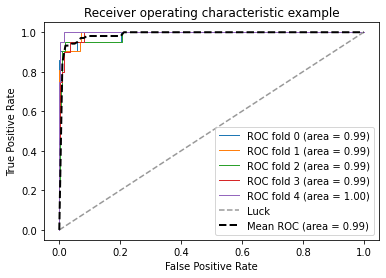

In [39]:
cv = StratifiedKFold(n_splits=5)
classifier = clf.best_estimator_

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train_idx, test_idx) in enumerate(cv.split(X,y)):
    classifier.fit(X[train_idx], y[train_idx])
    prob = classifier.predict_proba(X[test_idx])[:,1]
    fpr, tpr, thresholds = roc_curve(y[test_idx], prob)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= 5
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [40]:
classifier = clf.best_estimator_
classifier.fit(X,y)

test_lr = test.copy()
test_lr['prediction'] = classifier.predict_proba(test_data[selected_cols])[:,1]
test_lr[['bidder_id','prediction']].to_csv('lr_submission.csv',index=False)

## Random Forest Classifier

In [47]:
model = RandomForestClassifier()

parameters = {'bootstrap': [True, False],
               'max_depth': [5,10,15,20],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10,40,80],
               'n_estimators': [10,50,100,500],
               'class_weight':[{1:0.95,0:0.05}]}
              
clf = GridSearchCV(model, parameters, cv=3, scoring='roc_auc',n_jobs=-1, verbose=1)
clf.fit(X, y)

print('*'*100)
print('')
print("The best hyperparamters:")
print(clf.best_params_)
print('*'*100)

Fitting 3 folds for each of 960 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 458 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1258 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1808 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 2458 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 15.6min finished


****************************************************************************************************

The best hyperparamters:
{'bootstrap': True, 'class_weight': {1: 0.95, 0: 0.05}, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
****************************************************************************************************


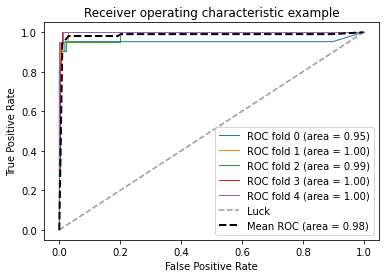

In [48]:
cv = StratifiedKFold(n_splits=5)
classifier = clf.best_estimator_

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train_idx, test_idx) in enumerate(cv.split(X,y)):
    classifier.fit(X[train_idx], y[train_idx])
    prob = classifier.predict_proba(X[test_idx])[:,1]
    fpr, tpr, thresholds = roc_curve(y[test_idx], prob)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= 5
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [49]:
classifier = clf.best_estimator_
classifier.fit(X,y)

test_rf = test.copy()
test_rf['prediction'] = classifier.predict_proba(test_data[selected_cols])[:,1]
test_rf[['bidder_id','prediction']].to_csv('rf_submission.csv',index=False)

## XGBoost Classifier

In [71]:
model = xgb()

parameters = {'max_depth':[5,10,15,20],'n_estimators':[10,50,100,500],'class_weight':[{1:0.95,0:0.05},{1:0.90,0:0.10},{1:0.8,0:0.2}]}
clf = GridSearchCV(model, parameters, cv=5, scoring='roc_auc',n_jobs=-1, verbose=1)
clf.fit(X, y) 

print('*'*100)
print('')
print("The best hyperparamters:")
print(clf.best_params_)
print('*'*100)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  9.2min finished


****************************************************************************************************

The best hyperparamters:
{'class_weight': {1: 0.95, 0: 0.05}, 'max_depth': 10, 'n_estimators': 500}
****************************************************************************************************


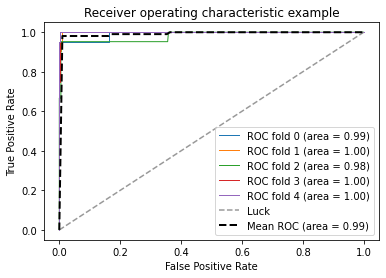

In [58]:
cv = StratifiedKFold(n_splits=5)
classifier = clf.best_estimator_

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train_idx, test_idx) in enumerate(cv.split(X,y)):
    classifier.fit(X[train_idx], y[train_idx])
    prob = classifier.predict_proba(X[test_idx])[:,1]
    fpr, tpr, thresholds = roc_curve(y[test_idx], prob)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= 5
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [81]:
classifier = clf.best_estimator_
classifier.fit(X,y)

test_xgb = test.copy()
test_xgb['prediction'] = classifier.predict_proba(np.array(test_data[selected_cols]))[:,1]
test_xgb[['bidder_id','prediction']].to_csv('xgb_submission.csv',index=False)

## AdaBoost Classifier

In [94]:
model = AdaBoostClassifier()

DTC1 = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = {1:0.95,0:0.05},max_depth = None)
DTC2 = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = {1:0.95,0:0.05},max_depth = 5)
DTC3 = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = {1:0.95,0:0.05},max_depth = 10)
DTC4 = DecisionTreeClassifier(random_state = 11, max_features = "auto", class_weight = {1:0.95,0:0.05},max_depth = 20)
parameters = {'n_estimators':[10,50,100,500],'learning_rate':[1e-2,1e-3,1e-4,1e-5],'base_estimator':[DTC1,DTC2,DTC3,DTC4],'algorithm':['SAMME','SAMME.R']}
clf = GridSearchCV(model, parameters, cv=5, scoring='roc_auc',n_jobs=-1, verbose=1)
clf.fit(X, y) 

print('*'*100)
print('')
print("The best hyperparamters:")
print(clf.best_params_)
print('*'*100)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:  2.8min finished


****************************************************************************************************

The best hyperparamters:
{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0: 0.05, 1: 0.95},
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=11, splitter='best'), 'learning_rate': 0.01, 'n_estimators': 500}
****************************************************************************************************


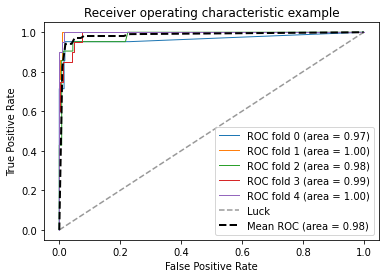

In [95]:
cv = StratifiedKFold(n_splits=5)
classifier = clf.best_estimator_

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train_idx, test_idx) in enumerate(cv.split(X,y)):
    classifier.fit(X[train_idx], y[train_idx])
    prob = classifier.predict_proba(X[test_idx])[:,1]
    fpr, tpr, thresholds = roc_curve(y[test_idx], prob)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= 5
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [96]:
clf = clf.best_estimator_
clf.fit(X,y)

test_xgb = test.copy()
test_xgb['prediction'] = clf.predict_proba(np.array(test_data[selected_cols]))[:,1]
test_xgb[['bidder_id','prediction']].to_csv('adb_submission.csv',index=False)